# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Aprendizaje no supervisado

### Trabajo práctico entregable - Grupo 22 - FIFA female players 2023 - Parte 2: implementación de modelos de ML

**Integrantes:**
- Chevallier-Boutell, Ignacio José
- Ribetto, Federico Daniel
- Rosa, Santiago
- Spano, Marcelo

**Seguimiento:** Meinardi, Vanesa

---

## Enunciados:

4- Aplicación de clustering para encontrar grupos de jugadoras con habilidades equivalentes, por ejemplo, jugadoras que podrían intercambiarse en el caso de una lesión o cuando una jugadora está cansada. Para esto utilice como mínimo dos técnicas de clustering: por ejemplo k-medias, DBSCAN, mezcla de Gaussianas y/o alguna jerárquica. Justifiquen por qué eligen los diferentes hiper-parámetros que se puedan elegir según el método: número de clusters, medida de distancia, criterio de aglomeración… 

5- Análisis cualitativo de los clusters encontrados. ¿Qué hay en cada cluster? ¿Son efectivamente equivalentes las jugadoras de un cluster, es decir, podrían cumplir el mismo rol en un equipo? Si se trata de clusters heterogéneos, ¿por qué razón pueden haber sido agrupadas las jugadoras del cluster? ¿Qué motiva las diferencias en tamaño?

6- Uso de alguna transformación (proyección, Embedding) para visualizar los resultados y/o usarla como preprocesado para aplicar alguna técnica de clustering.

## Librerías

Inicializamos el entorno.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.graph_objs as go

pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

from sklearn.cluster import KMeans,MeanShift
from plotly.offline import init_notebook_mode, plot,iplot
from sklearn.decomposition import PCA

## Lectura del dataset

Cargamos el conjunto de datos y lo procesamos para quedarnos sólo con lo que nos interesa.

In [2]:
path = 'fifa2023.csv'
fifa23 = pd.read_csv(path)

fifa_mod = fifa23[fifa23['pos_gral'] != 'arq'].copy() # Este df solo contiene variables numéricas
fifa_pos = fifa_mod.copy()

vars_mod = ['crossing', 'finishing', 'heading', 'short_passing', 'volleys', 
            'marking', 'standing_tackle', 'sliding_tackle', 'acceleration', 
            'sprint', 'agility', 'balance', 'shot_power', 'stamina', 
            'long_shots', 'dribbling', 'curve', 'fk_acc', 'long_passing', 
            'ball_control', 'aggression', 'interceptions', 'positioning', 
            'vision', 'penalties', 'composure', 'ls', 'st', 'rs', 'lw', 'lf', 
            'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 
            'rm', 'ldm', 'cdm', 'rdm', 'lwb', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 
            'rb']

# No resetear índices, para que después sea fácil buscar nombre y demás
fifa_mod = fifa_mod[vars_mod]
fifa_mod.shape

(6523, 52)

In [3]:
fifa_mod

crossing  finishing  heading  short_passing  volleys  marking  \
0           70         93       91             78       92       44   
1           51         70       96             84       55       93   
2           71         95       86             91       87       41   
3           71         94       93             84       90       42   
4           87         73       82             85       66       89   
...        ...        ...      ...            ...      ...      ...   
7420        49         55       42             61       51       55   
7421        59         48       50             59       56       60   
7422        37         49       45             63       47       31   
7423        55         53       48             52       24       55   
7424        52         56       57             60       52       15   

      standing_tackle  sliding_tackle  acceleration  sprint  agility  balance  \
0                  39              30            89      85       90       82   
1                  94              91            65      62       53       34   
2                  43              39            88      89       83       67   
3                  33              30            81      85       74       47   
4                  91              89            85      85       86       82   
...               ...             ...           ...     ...      ...      ...   
7420               57              59            73      75       70       71   
7421               50              51            53      55       62       66   
7422               37              39            66      54       71       47   
7423               57              54            62      61       59       67   
7424               33              33            63      67       59       78   

      shot_power  stamina  long_shots  dribbling  curve  fk_acc  long_passing  \
0             91       87          89         90     76      68            64   
1             85       75          65         69     65      58            87   
2             90       87          83         87     68      70            82   
3             86       75          89         91     79      75            72   
4             85       90          86         79     88      81            80   
...          ...      ...         ...        ...    ...     ...           ...   
7420          66       55          53         58     47      49            59   
7421          57       48          42         58     64      45            51   
7422          69       49          53         59     48      51            45   
7423          52       61          56         62     49      59            41   
7424          61       54          59         57     49      53            49   

      ball_control  aggression  interceptions  positioning  vision  penalties  \
0               92          70             24           95      79         75   
1               85          88             90           70      59         75   
2               93          53             46           92      75         88   
3               91          65             23           96      76         86   
4               85          82             85           73      73         62   
...            ...         ...            ...          ...     ...        ...   
7420            59          47             45           59      61         55   
7421            56          58             59           44      48         48   
7422            61          57             27           56      54         56   
7423            60          49             51           52      48         49   
7424            55          29             19           54      48         64   

      composure  ls  st  rs  lw  lf  cf  rf  rw  lam  cam  ram  lm  lcm  cm  \
0          92.0  91  91  91  87  89  89  89  87   89   89   89  88   81  81   
1          84.0  81  81  81  71  75  75  75  71   77   77   77  75   82  82 

---
# K-means clustering

El algoritmo K-means agrupa datos intentando separar muestras en `n` grupos de igual varianza, minimizando un criterio conocido como "inercia" o suma de cuadrados dentro del grupo. Tras especificar el número de clusters `K`, el algoritmo k-means divide un conjunto de `N` muestras `X` en `K` clusters disjuntos `C`, cada uno de los cuales se describe por la media $\mu_j$ de las muestras del cluster. Las medias se denominan comúnmente “centroides” del cluster, las cuales, en general, no son puntos de `X` aunque viven en el mismo espacio.

El objetivo de este algoritmo K-means es elegir centroides que minimicen la "inercia" o el criterio de suma de cuadrados dentro del grupo:

$\sum_{i = 0}^n \underset{\mu_j \in C}{\min} (\| x_i - \mu_j \|^2)$

La inercia puede reconocerse como una medida de cuán internamente coherentes son los clusters y tiene algunos inconvenientes:

- La inercia supone que los clusters son convexos e isotrópicos, lo que no siempre es así. Responde mal a clusters alargados o variedades con formas irregulares.

- La inercia no es una métrica normalizada: simplemente se sabe que los valores más bajos son mejores y cero es óptimo. Pero en espacios de muy altas dimensiones, las distancias euclidianas tienden a inflarse ("maldición de la dimensionalidad"). La ejecución de un algoritmo de reducción de dimensionalidad, como el análisis de componentes principales (PCA), antes de la clusterización con K-means puede aliviar este problema y acelerar los cálculos.

En términos básicos, el algoritmo consta de tres pasos. El primer paso elige los centroides iniciales, siendo el método más básico elegir `k` muestras del conjunto de datos `X`. Después de la inicialización, K-means consiste en realizar un bucle entre los pasos restantes. El primer paso asigna cada muestra a su centroide más cercano. El segundo paso crea nuevos centroides tomando el valor medio de todas las muestras asignadas a cada centroide anterior. Se calcula la diferencia entre los centroides antiguos y nuevos y el algoritmo repite estos dos últimos pasos hasta que este valor sea inferior a un umbral. En otras palabras, se repite hasta que los centroides no se mueven significativamente.

## Criterio del codo

Una forma de seleccionar la cantidad más adecuada de clusters es utilizar el "criterio del codo" con una medida de ajuste como la inercia. Fijando `n_init = 10`, siendo `n_init` el número de veces que se ejecuta el algoritmo con diferentes semillas de centroide, obtenemos la siguiente curva:

Text(0.5, 1.0, 'Inercia de K-Means vs Número de clusters')

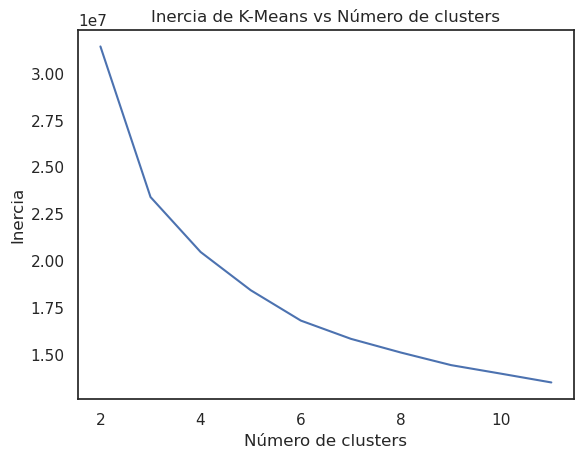

In [4]:
scores = [KMeans(n_clusters=i,n_init=10).fit(fifa_mod).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Número de clusters')
plt.ylabel("Inercia")
plt.title("Inercia de K-Means vs Número de clusters")

## Análisis de los clusters

Vemos que el codo se ubica aproximadamente alrededor de `K = 4`, por lo que tomaremos este valor para los análisis siguientes. Ahora aplicamos el algoritmo K-means y agregamos una nueva columna a la database conteniendo el cluster al que fue asignado cada dato.

In [5]:
n_K = 4 # Número de clusters

km = KMeans(n_clusters=n_K,n_init=10)
km.fit(fifa_mod)

clusters = km.labels_ # Etiquetas asignadas por el algoritmo

In [6]:
df_clusters = fifa_mod.copy()
df_clusters['ncluster'] = km.labels_ # Creamos una nueva columna con el cluster asignado
df_clusters.head()

crossing  finishing  heading  short_passing  volleys  marking  \
0        70         93       91             78       92       44   
1        51         70       96             84       55       93   
2        71         95       86             91       87       41   
3        71         94       93             84       90       42   
4        87         73       82             85       66       89   

   standing_tackle  sliding_tackle  acceleration  sprint  agility  balance  \
0               39              30            89      85       90       82   
1               94              91            65      62       53       34   
2               43              39            88      89       83       67   
3               33              30            81      85       74       47   
4               91              89            85      85       86       82   

   shot_power  stamina  long_shots  dribbling  curve  fk_acc  long_passing  \
0          91       87          89         90     76      68            64   
1          85       75          65         69     65      58            87   
2          90       87          83         87     68      70            82   
3          86       75          89         91     79      75            72   
4          85       90          86         79     88      81            80   

   ball_control  aggression  interceptions  positioning  vision  penalties  \
0            92          70             24           95      79         75   
1            85          88             90           70      59         75   
2            93          53             46           92      75         88   
3            91          65             23           96      76         86   
4            85          82             85           73      73         62   

   composure  ls  st  rs  lw  lf  cf  rf  rw  lam  cam  ram  lm  lcm  cm  rcm  \
0       92.0  91  91  91  87  89  89  89  87   89   89   89  88   81  81   81   
1       84.0  81  81  81  71  75  75  75  71   77   77   77  75   82  82   82   
2       92.0  90  90  90  87  89  89  89  87   90   90   90  89   85  85   85   
3       86.0  91  91  91  87  89  89  89  87   90   90   90  88   81  81   81   
4       86.0  84  84  84  82  81  81  81  82   84   84   84  85   85  85   85   

   rm  ldm  cdm  rdm  lwb  rwb  lb  lcb  cb  rcb  rb  ncluster  
0  88   65   65   65   67   67  64   61  61   61  64         3  
1  75   90   90   90   83   83  85   91  91   91  85         0  
2  89   70   70   70   72   72  69   63  63   63  69         3  
3  88   64   64   64   66   66  63   59  59   59  63         3  
4  85   89   89   89   89   89  89   89  89   89  89         3

In [7]:
df_clusters_pos = fifa_pos.copy()
df_clusters_pos['ncluster'] = km.labels_ # Creamos una nueva columna con el cluster asignado
df_clusters_pos.head()

name    nationality  age  height pos_gral position  preferred_foot  \
0       S. Kerr      Australia   28     168      del       ST               1   
1     W. Renard         France   31     187      def       CB               1   
2     A. Morgan  United States   32     168      del       ST               0   
3  A. Hegerberg         Norway   26     176      del       ST               1   
4     L. Bronze        England   30     171      def       RB               1   

   weak_foot  att_work_rate  def_work_rate  overall  potential  crossing  \
0          4            1.0            1.0       91         91        70   
1          3            1.0            0.5       91         91        51   
2          4            1.0            0.0       90         90        71   
3          4            1.0            0.5       90         91        71   
4          3            1.0            1.0       89         89        87   

   finishing  heading  short_passing  volleys  marking  standing_tackle  \
0         93       91             78       92       44               39   
1         70       96             84       55       93               94   
2         95       86             91       87       41               43   
3         94       93             84       90       42               33   
4         73       82             85       66       89               91   

   sliding_tackle  acceleration  sprint  agility  reactions  balance  \
0              30            89      85       90         91       82   
1              91            65      62       53         90       34   
2              39            88      89       83         84       67   
3              30            81      85       74         92       47   
4              89            85      85       86         89       82   

   shot_power  jumping  stamina  strength  long_shots  dribbling  curve  \
0          91       91       87        86          89         90     76   
1          85       86       75        93          65         69     65   
2          90       81       87        81          83         87     68   
3          86       89       75        81          89         91     79   
4          85       92       90        90          86         79     88   

   fk_acc  long_passing  ball_control  aggression  interceptions  positioning  \
0      68            64            92          70             24           95   
1      58            87            85          88             90           70   
2      70            82            93          53             46           92   
3      75            72            91          65             23           96   
4      81            80            85          82             85           73   

   vision  penalties  composure  diving  handling  kicking_gk  positioning_gk  \
0      79         75       92.0       7        12           8              16   
1      59         75       84.0       7        14          17              11   
2      75         88       92.0      11        11          10              10   
3      76         86       86.0      15         7          12              10   
4      73         62       86.0      10        14          16               8   

   reflexes  speed_gk  ls  st  rs  lw  lf  cf  rf  rw  lam  cam  ram  lm  lcm  \
0        13       NaN  91  91  91  87  89  89  89  87   89   89   89  88   81   
1        15       NaN  81  81  81  71  75  75  75  71   77   77   77  75   82   
2        11       NaN  90  90  90  87  89  89  89  87   90   90   90  89   85   
3        14       NaN  91  91  91  87  89  89  89  87   90   90   90  88   81   
4        15       NaN  84  84  84  82  81  81  81  82   84   84   84  85   85   

   cm  rcm  rm  ldm  cdm  rdm  lwb  rwb  lb  lcb  cb  rcb  rb  gk  ncluster  
0  81   81  88   65   65   65   67   67  64   61  61   61  64  23         3  
1  82   82  75   90   90   90   83   83  85   91  91   91  85  24         0  
2  85   85  89   70   70   70   72   

Para ver cómo se distribuyen los clusters, elegimos una feature correspondiente a posiciones ofensivas (por ej., `finishing`) y otra asociada a posiciones defensivas (por ej., `standing_tackle`). Haciendo un scatterplot obtenemos el siguiente gráfico:

In [8]:
skill_1 = vars_mod[1]
skill_2 = vars_mod[6]

kmeans_clusters = go.Scatter(x=df_clusters[skill_1], y=df_clusters[skill_2],
                             mode='markers',
                             marker=dict(
                             size=5,
                             color = clusters.astype(np.float), #set color equal to a variable
                             colorscale='Portland',
                             showscale=True)
                             )

layout = go.Layout(xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=kmeans_clusters, layout=layout)
fig.show()

/tmp/ipykernel_8910/92844990.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Veamos ahora las características de estos clusters. Comenzando con el tamaño, se tiene que los 4 clusters son relativamente parecidos. El cluster más grande agrupa aproximadamente el 29,4% de los datos (cluster 1), mientras que el más pequeño contiene el 18% (cluster 3).

In [9]:
df_clusters.ncluster.value_counts(normalize=True)

1    0.294343
0    0.290664
2    0.235474
3    0.179519
Name: ncluster, dtype: float64

Con respecto a la distribución de las posiciones de las jugadoras en los clusters, se observan ciertas preferencias en cada uno de ellos.

- Cluster 0: Las posiciones de mediocampista central y defensiva central conforman casi el 50% de los datos, mientras que el porcentaje restante es prácticamente ocupado por posiciones de defensor: defensora derecha, central e izquierda. Dada la naturaleza defensiva de todas estas posiciones, resulta natural que las jugadoras dentro de este cluster puedan ser intercambiadas. En resumen, la naturaleza de este cluster es de mediocampo y defensiva.


- Cluster 1: En este cluster el 50% de los datos está conformado por jugadoras de la posición ofensiva pateadora central. Luego se tiene que un 13% son mediocampistas ofensivas centrales, un 20% por mediocampistas derechas y mediocampistas izquierdas (12% + 8%), un 15% volantes delantera derecha e izquierda (8% + 7%). Todos estas posiciones se caracterizan por su carácter ofensivo y, al igual que antes, es factible que jugadoras de estas posiciones puedan reemplazarse entre sí. En resumen, la naturaleza de este cluster es ofensiva.


- Cluster 2: Aquí el 63% de las jugadoras son defensoras centrales, mientras que un 25% son defensoras izquierdas y derechas (13% + 12%). Además hay un 6% de mediocampistas defensivas centrales y un 4% de mediocampistas centrales. Se puede apreciar que predominan las mismas posiciones que en el cluster 0 solo que ahora hay mayor proporción de defensoras, haciendo que la naturaleza de este cluster sea defensiva.


- Cluster 3: En este cluster el 33% de los datos está conformado por mediocampistas centrales, un 15% por mediocampistas ofensivas centrales, un 10% por pateadoras centrales, un 9% por mediocampistas derechas, un 16% por volantes delanteras derechas e izquierdas (8.3% + 7.6%), un 5% por mediocampistas izquierdas, un 4% por mediocampistas defensivas centrales y un 6% por defensoras izquierdas y derechas (3% + 3%). Para este cluster, que es el más pequeño, no queda clara una tendencia general ya que contiene jugadoras de posiciones defensivas, de mediocampo y ofensivas. Viendo el scatterplot previo, este cluster se localiza entre los clusters 0 y 1, los cuales tienen naturaleza mediocampo/defensiva y ofensiva, respectivamente. Por lo tanto, es de esperar que este cluster tenga una tendencia mezcla de los clusters 0 y 1.

In [10]:
for n in range(n_K):
    print(n)
    df_pos = df_clusters_pos[df_clusters['ncluster']==n]
    print(df_pos.position.value_counts(normalize=True))

0
CM     0.252637
CDM    0.202004
RB     0.180380
CB     0.147152
LB     0.143987
LWB    0.013713
LM     0.013186
CAM    0.012658
RM     0.012131
RW     0.008966
RWB    0.008439
CF     0.004747
Name: position, dtype: float64
1
ST     0.497917
CAM    0.126042
RM     0.121354
RW     0.082812
LM     0.077604
LW     0.066146
CM     0.023438
CF     0.004687
Name: position, dtype: float64
2
CB     0.626302
LB     0.130859
RB     0.120443
CDM    0.063151
CM     0.038411
LWB    0.013021
RWB    0.007161
ST     0.000651
Name: position, dtype: float64
3
CM     0.331341
CAM    0.153715
ST     0.101623
RM     0.090521
RW     0.082835
LW     0.076003
LM     0.051238
CDM    0.039283
LB     0.029889
RB     0.028181
LWB    0.008540
CB     0.006832
Name: position, dtype: float64


## Análisis de componentes principales (PCA)

En esta sección vamos a utilizar PCA como transformación para visualizar los resultados obtenidos tras aplicar el algoritmo K-means. Comenzamos normalizando el dataset dividiendo todas las columnas por 100 ya que las mismas son todas numéricas y en el rango [0,99].

In [11]:
df_norm = fifa_mod.copy()

df_norm = df_norm/100.
df_norm

crossing  finishing  heading  short_passing  volleys  marking  \
0         0.70       0.93     0.91           0.78     0.92     0.44   
1         0.51       0.70     0.96           0.84     0.55     0.93   
2         0.71       0.95     0.86           0.91     0.87     0.41   
3         0.71       0.94     0.93           0.84     0.90     0.42   
4         0.87       0.73     0.82           0.85     0.66     0.89   
...        ...        ...      ...            ...      ...      ...   
7420      0.49       0.55     0.42           0.61     0.51     0.55   
7421      0.59       0.48     0.50           0.59     0.56     0.60   
7422      0.37       0.49     0.45           0.63     0.47     0.31   
7423      0.55       0.53     0.48           0.52     0.24     0.55   
7424      0.52       0.56     0.57           0.60     0.52     0.15   

      standing_tackle  sliding_tackle  acceleration  sprint  agility  balance  \
0                0.39            0.30          0.89    0.85     0.90     0.82   
1                0.94            0.91          0.65    0.62     0.53     0.34   
2                0.43            0.39          0.88    0.89     0.83     0.67   
3                0.33            0.30          0.81    0.85     0.74     0.47   
4                0.91            0.89          0.85    0.85     0.86     0.82   
...               ...             ...           ...     ...      ...      ...   
7420             0.57            0.59          0.73    0.75     0.70     0.71   
7421             0.50            0.51          0.53    0.55     0.62     0.66   
7422             0.37            0.39          0.66    0.54     0.71     0.47   
7423             0.57            0.54          0.62    0.61     0.59     0.67   
7424             0.33            0.33          0.63    0.67     0.59     0.78   

      shot_power  stamina  long_shots  dribbling  curve  fk_acc  long_passing  \
0           0.91     0.87        0.89       0.90   0.76    0.68          0.64   
1           0.85     0.75        0.65       0.69   0.65    0.58          0.87   
2           0.90     0.87        0.83       0.87   0.68    0.70          0.82   
3           0.86     0.75        0.89       0.91   0.79    0.75          0.72   
4           0.85     0.90        0.86       0.79   0.88    0.81          0.80   
...          ...      ...         ...        ...    ...     ...           ...   
7420        0.66     0.55        0.53       0.58   0.47    0.49          0.59   
7421        0.57     0.48        0.42       0.58   0.64    0.45          0.51   
7422        0.69     0.49        0.53       0.59   0.48    0.51          0.45   
7423        0.52     0.61        0.56       0.62   0.49    0.59          0.41   
7424        0.61     0.54        0.59       0.57   0.49    0.53          0.49   

      ball_control  aggression  interceptions  positioning  vision  penalties  \
0             0.92        0.70           0.24         0.95    0.79       0.75   
1             0.85        0.88           0.90         0.70    0.59       0.75   
2             0.93        0.53           0.46         0.92    0.75       0.88   
3             0.91        0.65           0.23         0.96    0.76       0.86   
4             0.85        0.82           0.85         0.73    0.73       0.62   
...            ...         ...            ...          ...     ...        ...   
7420          0.59        0.47           0.45         0.59    0.61       0.55   
7421          0.56        0.58           0.59         0.44    0.48       0.48   
7422          0.61        0.57           0.27         0.56    0.54       0.56   
7423          0.60        0.49           0.51         0.52    0.48       0.49   
7424          0.55        0.29           0.19         0.54    0.48       0.64   

      composure    ls    st    rs    lw    lf    cf    rf    rw   lam   cam  \
0          0.92  0.91  0.91  0.91  0.87  0.89  0.89  0.89  0.87  0.89  0.89   
1          0.84  0.81  0.81  0.81  0.71  0.75  0.75  0.75  0.71  0.77  0.77 

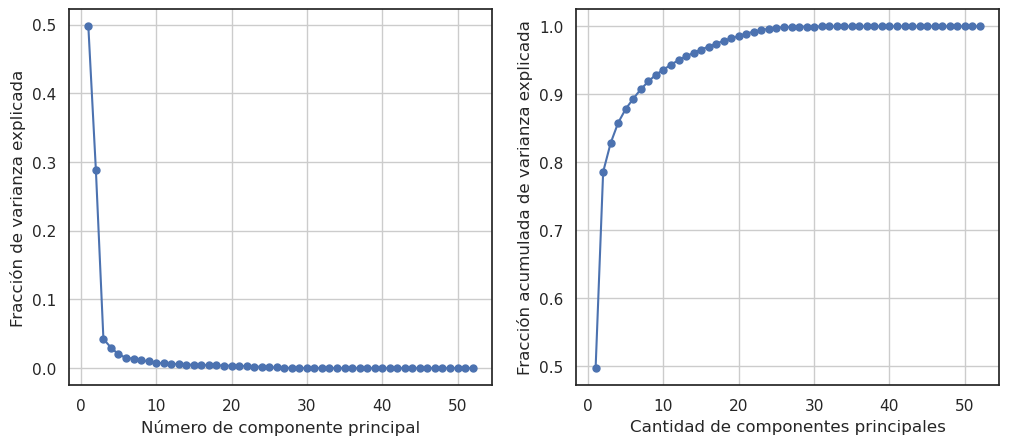

In [18]:
pca = PCA(n_components=None)
pca.fit(df_norm)

df_norm_pca = pca.transform(df_norm) # Llevamos la matriz al espacio de componentes principales

evr = pca.explained_variance_ratio_

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 10)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')
ax[0].grid()

varianza_acumulada = np.cumsum(evr)
ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 10)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')
ax[1].grid()

fig.subplots_adjust(top=1.05)

En el segundo gráfico vemos que, reteniendo solamente 6 componentes principales, mantenemos cerca del 90% de la información original.

Veamos qué nos dicen las primeras 2 componentes (las cuales contienen casi el 80% de la información), con el fin de luego realizar un análisis gráfico en 2 dimensiones.

Veamos ahora cómo contribuyen las features a las dos primeras componentes principales y cómo los datos se distribuyen en el espacio que describen estas componentes.

Text(0, 0.5, 'Segunda componente principal')

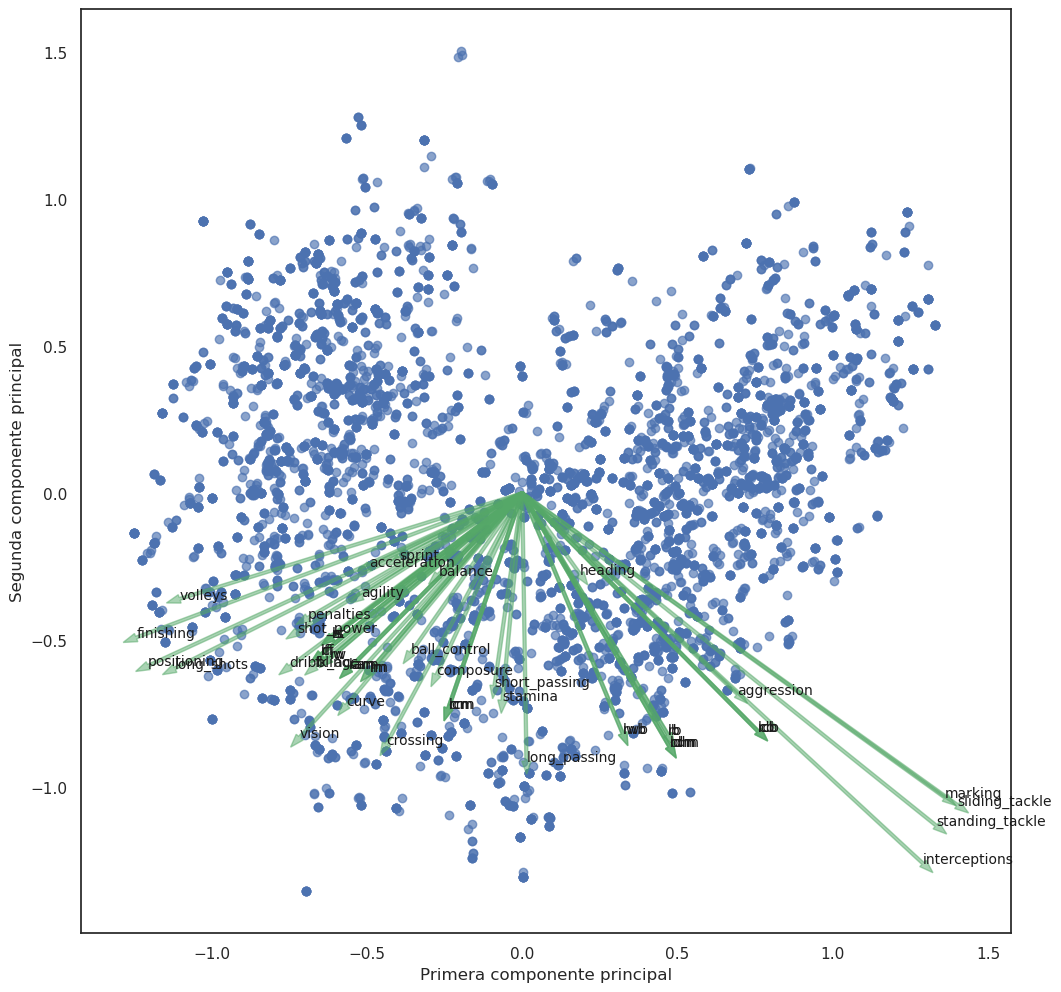

In [22]:
features = ['crossing', 'finishing', 'heading', 'short_passing', 'volleys', 
            'marking', 'standing_tackle', 'sliding_tackle', 'acceleration', 
            'sprint', 'agility', 'balance', 'shot_power', 'stamina', 
            'long_shots', 'dribbling', 'curve', 'fk_acc', 'long_passing', 
            'ball_control', 'aggression', 'interceptions', 'positioning', 
            'vision', 'penalties', 'composure', 'ls', 'st', 'rs', 'lw', 'lf', 
            'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 
            'rm', 'ldm', 'cdm', 'rdm', 'lwb', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 
            'rb']
features_pc = pca.components_.T

fig, ax = plt.subplots(figsize = (12, 12))

# Hacemos un scatter de los datos en las dos primeras componentes
ax.scatter(df_norm_pca[:,0], df_norm_pca[:,1], alpha = 0.65)

# Hacemos el grafico de las flechas indicando las direcciones de los features originales
sf = 5 # Factor de escala para agrandar las flechas

for i in range(len(features)):

  ax.arrow(0, 0, sf * features_pc[i][0], sf * features_pc[i][1], width = 0.01, color = 'g', alpha = 0.5)
  ax.text(sf * features_pc[i][0], sf * features_pc[i][1], s = features[i], fontdict= {'color': 'k', 'size': 10})

ax.set_xlabel('Primera componente principal')
ax.set_ylabel('Segunda componente principal')

A partir del gráfico anterior es posible apreciar que las features relacionadas a habilidades defensivas toman valores positivos en el eje de la primera componente principal y negativos en el eje de la segunda comopnente principal. Por otro lado, las habilidades ofensivas toman valores negativos en el eje de la primera componente principal y también negativos en el eje de la segunda componente.

In [24]:
df_norm_pca_projected = pd.DataFrame(df_norm_pca)
df_norm_pca_projected['ncluster'] = clusters
df_norm_pca_projected

0         1         2         3         4         5         6  \
0    -1.139820 -0.462601  0.194998 -0.371291  0.095082 -0.057043 -0.104933   
1     0.451340 -0.936220  0.614713 -0.121945  0.020224  0.018441  0.125447   
2    -1.012390 -0.622034  0.218880 -0.266212  0.126497  0.063157  0.012252   
3    -1.159686 -0.397033  0.410173 -0.300936 -0.030696  0.152201  0.089140   
4     0.002286 -1.289287 -0.010869 -0.212341 -0.135824 -0.189909 -0.002533   
...        ...       ...       ...       ...       ...       ...       ...   
6518  0.103076  0.589933 -0.112803  0.147265 -0.003798 -0.161501 -0.002223   
6519  0.352847  0.721131  0.003385  0.115908 -0.288372 -0.082330 -0.011711   
6520 -0.098168  1.053211  0.133408  0.134701 -0.092952 -0.001685 -0.082324   
6521  0.304869  0.759824 -0.082126  0.142099 -0.142547 -0.150281  0.077681   
6522 -0.317089  1.201626 -0.041859  0.072095 -0.117594 -0.085110  0.029531   

             7         8         9        10        11        12        13  \
0    -0.074505  0.063680  0.020249  0.008836 -0.023550 -0.049566 -0.017154   
1    -0.005127 -0.096924  0.085144  0.003714 -0.051086 -0.009384  0.042145   
2     0.113146 -0.035293  0.043838 -0.104610  0.003919  0.049211 -0.032288   
3    -0.049826 -0.082071  0.067125  0.023656  0.015574 -0.045636 -0.024863   
4     0.026081 -0.035157  0.019267  0.072348 -0.118444 -0.007731  0.014606   
...        ...       ...       ...       ...       ...       ...       ...   
6518  0.000979 -0.130459  0.086762  0.009155 -0.063697 -0.006326 -0.056147   
6519 -0.154823  0.100494  0.094550 -0.126963  0.043304  0.048496  0.015277   
6520 -0.121930 -0.142439  0.067773  0.040585 -0.093353 -0.047971  0.061088   
6521  0.054583 -0.054974 -0.107778  0.127407  0.036258  0.024159  0.162366   
6522  0.194661  0.077524 -0.031017  0.022102 -0.059096 -0.044474 -0.070065   

            14        15        16        17        18        19        20  \
0     0.066201 -0.066701 -0.074367 -0.092363  0.078804 -0.007838 -0.057204   
1    -0.092345  0.147065  0.006357  0.006909  0.005237 -0.087879 -0.003465   
2     0.033991  0.104600  0.006534  0.044449 -0.000012 -0.020869 -0.001962   
3    -0.043519 -0.002147 -0.044208 -0.033508  0.063980 -0.005688 -0.022041   
4     0.023574 -0.071861 -0.046166  0.015273  0.057493 -0.004840 -0.069656   
...        ...       ...       ...       ...       ...       ...       ...   
6518  0.036666  0.082009  0.093586 -0.095821  0.016326  0.009857 -0.051278   
6519  0.042451 -0.003529  0.002935 -0.001869 -0.041889  0.028133 -0.081996   
6520  0.046943  0.128624 -0.047415 -0.043772  0.016312  0.007126  0.057693   
6521 -0.034830  0.012082 -0.075502 -0.060248  0.000237  0.081971 -0.047699   
6522  0.063886  0.066629  0.000710 -0.022641 -0.085502  0.024808 -0.010127   

            21        22        23        24        25        26        27  \
0    -0.018368  0.019793  0.027956 -0.062012  0.043587 -0.019042  0.011855   
1     0.030423  0.051818  0.008673  0.018307  0.031893  0.013705  0.033963   
2    -0.004888 -0.000236 -0.001075  0.003375 -0.012929  0.008080 -0.007644   
3     0.030261 -0.030356 -0.010445 -0.005974 -0.002243  0.004112  0.022947   
4    -0.005178 -0.000295  0.023825 -0.001132  0.007213 -0.030282  0.015907   
...        ...       ...       ...       ...       ...       ...       ...   
6518 -0.018161  0.009253 -0.053104  0.012053 -0.014978 -0.011978 -0.020657   
6519 -0.048430  0.033271 -0.025745  0.009800 -0.031549 -0.015414  0.006366   
6520  0.001157  0.043428  0.086049  0.008969 -0.060296 -0.015575 -0.001501   
6521 -0.035846  0.038755 -0.000600 -0.006059  0.013765 -0.020749 -0.030339   
6522  0.043961 -0.017693 -0.056574 -0.000250 -0.048870 -0.009712  0.003804   

            28        29        30        31        32        33        34  \
0    -0.012465  0.024318 -0.008583 -0.003323  0.002849  0.004243 -0.000865   
1     0.016067 -0.001185  0.001342 -0.012306 -0.007129 -0.003195  0.002967   
2    -0.023309  0.017009 -0.011

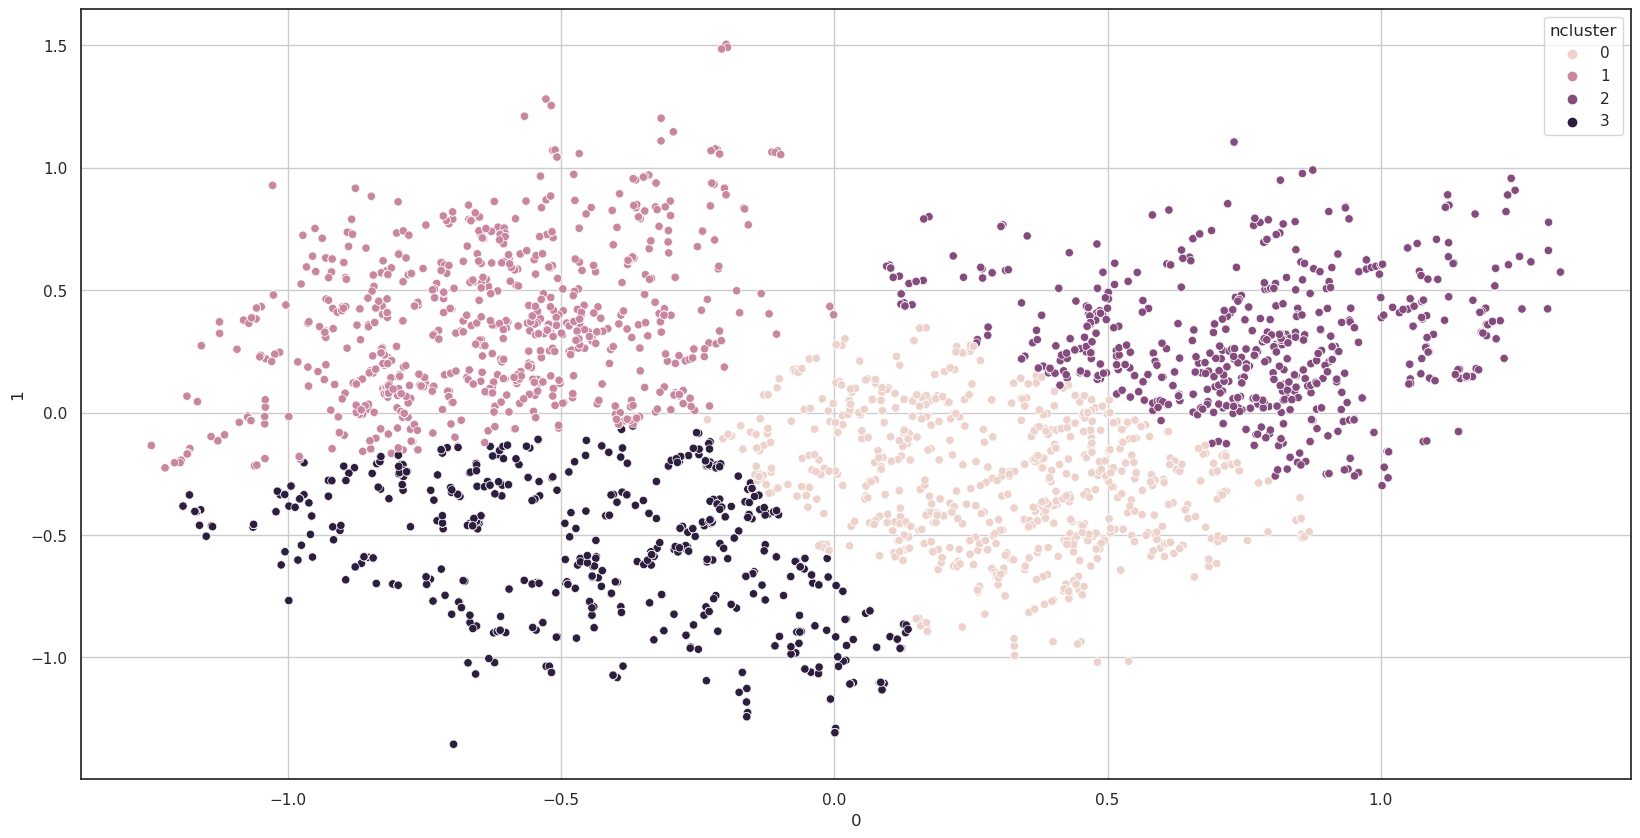

In [26]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_norm_pca_projected, x=0, y=1, hue='ncluster')
plt.grid()
plt.show()

En esta nueva gráfica vemos que el cluster 0 (de carácter mediocampo/defensivo) y el cluster 2 (de carácter defensivo) se localizan en la región derecha, lo cual tiene sentido ya que en esa dirección juegan un rol importante las habilidades defensivas. Además, los clusters restantes (con naturalezas más ofensivas) de ubican del lado izquierdo, sentido en el que pesan más las habilidades ofensivas.